# Autoencoder

This is a 4 layers Autoencoder(2 encoder + 2 decoder) for performing dimensionality reduction on the GEFCOM-2014 load forecasting data

In [8]:
import numpy as np
import pandas as pd
from datetime import date, timedelta, datetime
import os
import pickle
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable
from matplotlib.pyplot import figure

# Data Preprocessing & Staging

In [9]:
def get_data(file_name):
    data = pd.read_csv(file_name)
    data = data.to_numpy()
    for i in range(data.shape[0]):
        data[i, 1] = datetime.strptime(data[i, 1], "%m%d%Y %H:%M").date()
    power = data[:, 2].astype(np.float64)
    indexes = np.isnan(power)
    cleaned_data = data[~indexes, :]
    return cleaned_data

def embed_data(lead_time, embed_dim, from_date, to_date, data, t_idx, dt_idx):
    start = np.where(data[:, dt_idx] == from_date)[0][0]
    end = np.where(data[:, dt_idx] == to_date)[0][-1]
    X, y = [], []
    for idx in range(start, end+1):
        xx = data[idx-(embed_dim+lead_time-1):idx-lead_time+1, 3:]
        yy = data[idx, 2]
        X.append(xx)
        y.append(yy)
    return np.array(X), np.array(y)

def get_data_between_time(data, from_date, to_date, dt_idx):
    start = np.where(data[:, dt_idx] == from_date)[0][0]
    end = np.where(data[:, dt_idx] == to_date)[0][-1]
    return data[start:(end+1), :]


def normalize(data):
    for i in range(2, data.shape[1]):
        data[:, i] = (data[:, i] - np.mean(data[:, i]))/np.std(data[:, i])
    return data

In [12]:
data = get_data('./data/task_1/L1-train.csv')
data = normalize(data)
embedded_data, target = embed_data(
    lead_time = 6,
    embed_dim = 12,
    from_date = date(month=2, year=2005, day=1),
    to_date = date(month=4, year=2005, day=30),
    data = data,
    t_idx = 2,
    dt_idx = 1
)

In [13]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, down_size):
        super().__init__()
        self.input_size = input_size
        self.down_size = down_size
        
        self.factor = input_size / down_size
        self.encoded_size = self.down_size
        
        self.factor_root = np.sqrt(self.factor)
        self.first_squash = int(input_size / self.factor_root)
        
        self.linear_encode1 = nn.Linear(self.input_size, self.first_squash)
        self.linear_encode2 = nn.Linear(self.first_squash, self.encoded_size)
        
        self.linear_decode1 = nn.Linear(self.encoded_size, self.first_squash)
        self.linear_decode2 = nn.Linear(self.first_squash, self.input_size)
        
        # Activation
        self.first_squash_fn = nn.ELU()
        self.encode_fn = nn.Sigmoid()
        
    def forward(self, xx, decode = True, no_act = False):
        if no_act:
            xx = self.linear_encode1(xx)
            xx = self.linear_encode2(xx)

            if decode : 
                xx = self.linear_decode1(xx)
                xx = self.linear_decode2(xx) 
        else:
            xx = self.first_squash_fn( self.linear_encode1(xx) )
            xx = self.encode_fn(self.linear_encode2(xx))

            if decode : 
                xx = self.encode_fn(self.linear_decode1(xx))
                xx = self.first_squash_fn( self.linear_decode2(xx) )   
                
        return xx
    
    def train(self, data, batch_size, epochs = 30, lr = 0.01, no_act = False):
        learning_rate = 0.01
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr = lr)
        losses = []
        # Train the model
        for epoch in range(epochs):  
            indices = torch.randperm(data.size()[0])
            data = data[indices, :]
            for i in range(0, data.size()[0], batch_size):
                xx = data[i: i + batch_size, :]
                outputs = self.forward(xx, no_act = no_act)
                optimizer.zero_grad()
                
                loss = criterion(outputs, xx)
                losses.append(loss.item())
                
                loss.backward()
                optimizer.step()
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        return losses

In [14]:
ae_data = get_data_between_time(
    data = data,
    from_date = date(month=1, year=2005, day=1),
    to_date = date(month=12, year=2005, day=31),
    dt_idx=1
)

ae_data = Variable(torch.from_numpy(ae_data[:, 3:].astype(np.float32)))

autoencoder = Autoencoder(
    input_size = 25,
    down_size = 15
)

losses = autoencoder.train(
    data = ae_data, 
    batch_size = 20, 
    epochs = 200, 
    lr = 0.000005,
    no_act = True
)

Epoch: 0, loss: 1.13016
Epoch: 1, loss: 0.99306
Epoch: 2, loss: 1.52001
Epoch: 3, loss: 1.12809
Epoch: 4, loss: 0.63293
Epoch: 5, loss: 0.97349
Epoch: 6, loss: 0.71205
Epoch: 7, loss: 0.68225
Epoch: 8, loss: 0.56654
Epoch: 9, loss: 0.49833
Epoch: 10, loss: 0.49267
Epoch: 11, loss: 0.35852
Epoch: 12, loss: 0.31349
Epoch: 13, loss: 0.33022
Epoch: 14, loss: 0.23313
Epoch: 15, loss: 0.14945
Epoch: 16, loss: 0.16328
Epoch: 17, loss: 0.10911
Epoch: 18, loss: 0.11331
Epoch: 19, loss: 0.09492
Epoch: 20, loss: 0.06741
Epoch: 21, loss: 0.06959
Epoch: 22, loss: 0.06522
Epoch: 23, loss: 0.06770
Epoch: 24, loss: 0.08926
Epoch: 25, loss: 0.07173
Epoch: 26, loss: 0.06039
Epoch: 27, loss: 0.06844
Epoch: 28, loss: 0.04619
Epoch: 29, loss: 0.05796
Epoch: 30, loss: 0.05649
Epoch: 31, loss: 0.04856
Epoch: 32, loss: 0.03773
Epoch: 33, loss: 0.05568
Epoch: 34, loss: 0.03286
Epoch: 35, loss: 0.04428
Epoch: 36, loss: 0.04804
Epoch: 37, loss: 0.05483
Epoch: 38, loss: 0.05137
Epoch: 39, loss: 0.04322
Epoch: 40,

In [15]:
# torch.save(autoencoder.state_dict(), './data/autoencoder_params')

# new_autoencoder = Autoencoder(
#     input_size = 25,
#     down_size = 15
# )

# new_autoencoder.load_state_dict(torch.load('./data/autoencoder_params'))

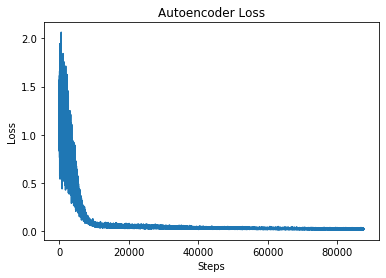

In [16]:
plt.plot(losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Autoencoder Loss')
plt.show()

## New Reduced Data

In [17]:
dataTensor = Variable(torch.from_numpy(data[:, 3:].astype(np.float32)))
encoded_data_without_date = autoencoder.forward(dataTensor, decode=False, no_act=True).detach().numpy()
encoded_data = np.concatenate((data[:, :3], encoded_data_without_date), axis=1)
embedded_encoded_data, target = embed_data(
    lead_time = 6,
    embed_dim = 12,
    from_date = date(month=1, year=2006, day=1),
    to_date = date(month=3, year=2006, day=31),
    data = encoded_data,
    t_idx = 2,
    dt_idx = 1
)

# LSTM for forecasting

In [18]:
class QuantileRegression(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, seq_length):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 10)
        self.fc_out = nn.Linear(10, output_size)
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        batch_size = x.size(0)
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(batch_size*self.num_layers, self.hidden_size)
#         print(ula.size(), h_out.size())
#         h_out = h_out.view(-1, self.hidden_size)
        
#         ula = ula.contiguous().view(x.size(0),-1)
        
        fc1 = self.fc(h_out)
        out = self.fc_out(fc1)
        
        return out
    
    def train_model(self, trainX, trainY, lr, epochs, sample_size, alpha):
        learning_rate = lr
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        losses = []
        num_epochs = epochs
        
        for epoch in range(num_epochs):  
            indices = torch.randperm(trainX.size()[0])
            trainX, trainY = trainX[indices, :, :], trainY[indices]
            for i in range(0, trainX.size()[0], sample_size):
                xx = trainX[i: i + sample_size, :, :]
                yy = trainY[i: i + sample_size]
                outputs = self.forward(xx)
                outputs = outputs.view(self.num_layers, self.output_size, -1)
                optimizer.zero_grad()
                # obtain the loss function
                loss = self.quantile_loss(outputs[-1, :, :], yy, alpha)
                losses.append(loss.item())
                loss.backward()

                optimizer.step()
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
            
        return losses
    
    def train_sgd(self, trainX, trainY, lr, epochs, sample_size):
        learning_rate = lr
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        losses = []
        num_epochs = epochs
        for epoch in range(num_epochs):
            for xx, yy in zip(trainX, trainY):
                xx = xx.view(1, self.seq_length, self.input_size)
                outputs = self.forward(xx)
                optimizer.zero_grad()

                # obtain the loss function
                loss = self.quantile_loss(outputs, yy, alpha=0.9)
                losses.append(loss)
                loss.backward()

                optimizer.step()
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        return losses
    
    def quantile_loss(self, output, target, alpha = 0.5):
        covered_flag = (output <= target).float()
        uncovered_flag = (output > target).float()
        return torch.mean((target - output)*(alpha)*covered_flag + (output-target)*(1-alpha)*uncovered_flag)

In [19]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from matplotlib.pyplot import figure


# RNNs模型基类，主要是用于指定参数和cell类型
class BaseModel(nn.Module):

    def __init__(self, inputDim, hiddenNum, outputDim, layerNum, cell, use_cuda=False):

        super(BaseModel, self).__init__()
        self.hiddenNum = hiddenNum
        self.inputDim = inputDim
        self.outputDim = outputDim
        self.layerNum = layerNum
        self.use_cuda = use_cuda
        if cell == "RNN":
            self.cell = nn.RNN(input_size=self.inputDim, hidden_size=self.hiddenNum,
                        num_layers=self.layerNum, dropout=0.0,
                         nonlinearity="tanh", batch_first=True,)
        if cell == "LSTM":
            self.cell = nn.LSTM(input_size=self.inputDim, hidden_size=self.hiddenNum,
                               num_layers=self.layerNum, dropout=0.0,
                               batch_first=True, )
        if cell == "GRU":
            self.cell = nn.GRU(input_size=self.inputDim, hidden_size=self.hiddenNum,
                                num_layers=self.layerNum, dropout=0.0,
                                 batch_first=True, )
        print(self.cell)
        self.fc = nn.Linear(self.hiddenNum, self.outputDim)


# 标准RNN模型
class RNNModel(BaseModel):

    def __init__(self, inputDim, hiddenNum, outputDim, layerNum, cell, use_cuda):

        super(RNNModel, self).__init__(inputDim, hiddenNum, outputDim, layerNum, cell, use_cuda)

    def forward(self, x):

        batchSize = x.size(0)
        h0 = Variable(torch.zeros(self.layerNum * 1, batchSize , self.hiddenNum))
        if self.use_cuda:
            h0 = h0.cuda()
        rnnOutput, hn = self.cell(x, h0)
        hn = hn.view(batchSize, self.hiddenNum)
        fcOutput = self.fc(hn)

        return fcOutput


# LSTM模型
class LSTMModel(BaseModel):

    def __init__(self, inputDim, hiddenNum, outputDim, layerNum, cell, use_cuda):
        super(LSTMModel, self).__init__(inputDim, hiddenNum, outputDim, layerNum, cell, use_cuda)

    def forward(self, x):
        batchSize = x.size(0)
        h0 = Variable(torch.zeros(self.layerNum * 1, batchSize, self.hiddenNum))
        c0 = Variable(torch.zeros(self.layerNum * 1, batchSize, self.hiddenNum))
        if self.use_cuda:
            h0 = h0.cuda()
            c0 = c0.cuda()
        rnnOutput, hn = self.cell(x, (h0, c0))
        hn = hn[0].view(self.layerNum * batchSize, self.hiddenNum)
        fcOutput = self.fc(hn)

        return fcOutput
    
    
lstm_model = LSTMModel(
    inputDim = 25,
    hiddenNum = 60,
    outputDim = 1,
    layerNum = 1,
    cell = "LSTM",
    use_cuda = False
)

def quantile_loss(output, target, alpha = 0.5):
#     print(output.size(), target.size())
    covered_flag = (output <= target).float()
    uncovered_flag = (output > target).float()
    return torch.mean((target - output)*(alpha)*covered_flag + (output-target)*(1-alpha)*uncovered_flag)

learning_rate = 0.01
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
losses = []
num_epochs = 1
print(embedded_data.shape)
criterion = torch.nn.MSELoss()
train_x = embedded_data.astype(np.float32)
train_y = target.astype(np.float32)

trainX = Variable(torch.from_numpy(train_x))
trainY = Variable(torch.from_numpy(train_y))
# Train the model
for epoch in range(num_epochs):
    for xx, yy in zip(trainX, trainY):
        xx = xx.view(1, 12, 25)
        outputs = lstm_model.forward(xx)
        optimizer.zero_grad()

        # obtain the loss function
        loss = quantile_loss(outputs, yy, alpha=0.9)
        losses.append(loss)
        loss.backward()

        optimizer.step()
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    

LSTM(25, 60, batch_first=True)
(2136, 12, 25)
Epoch: 0, loss: 0.07065


Epoch: 0, loss: 0.11881
Epoch: 1, loss: 0.19918
Epoch: 2, loss: 0.11380
Epoch: 3, loss: 0.13192
Epoch: 4, loss: 0.09743
Epoch: 5, loss: 0.11932
Epoch: 6, loss: 0.10014
Epoch: 7, loss: 0.09272
Epoch: 8, loss: 0.11687
Epoch: 9, loss: 0.14058
Epoch: 10, loss: 0.07668
Epoch: 11, loss: 0.06996
Epoch: 12, loss: 0.09701
Epoch: 13, loss: 0.08306
Epoch: 14, loss: 0.08586
Epoch: 15, loss: 0.06273
Epoch: 16, loss: 0.07572
Epoch: 17, loss: 0.10282
Epoch: 18, loss: 0.08334
Epoch: 19, loss: 0.06948
Epoch: 20, loss: 0.06065
Epoch: 21, loss: 0.06189
Epoch: 22, loss: 0.05925
Epoch: 23, loss: 0.06466
Epoch: 24, loss: 0.05563
Epoch: 25, loss: 0.06558
Epoch: 26, loss: 0.07795
Epoch: 27, loss: 0.07427
Epoch: 28, loss: 0.06472
Epoch: 29, loss: 0.07039
Epoch: 30, loss: 0.06048
Epoch: 31, loss: 0.06486
Epoch: 32, loss: 0.06399
Epoch: 33, loss: 0.12231
Epoch: 34, loss: 0.06263
Epoch: 35, loss: 0.06687
Epoch: 36, loss: 0.07065
Epoch: 37, loss: 0.05575
Epoch: 38, loss: 0.04920
Epoch: 39, loss: 0.06511
Epoch: 40,

Epoch: 123, loss: 0.02631
Epoch: 124, loss: 0.02662
Epoch: 125, loss: 0.03260
Epoch: 126, loss: 0.02712
Epoch: 127, loss: 0.02461
Epoch: 128, loss: 0.02458
Epoch: 129, loss: 0.02879
Epoch: 130, loss: 0.02159
Epoch: 131, loss: 0.02300
Epoch: 132, loss: 0.03737
Epoch: 133, loss: 0.04262
Epoch: 134, loss: 0.02591
Epoch: 135, loss: 0.02695
Epoch: 136, loss: 0.03344
Epoch: 137, loss: 0.02175
Epoch: 138, loss: 0.01601
Epoch: 139, loss: 0.01702
Epoch: 140, loss: 0.02397
Epoch: 141, loss: 0.02963
Epoch: 142, loss: 0.02075
Epoch: 143, loss: 0.02442
Epoch: 144, loss: 0.02562
Epoch: 145, loss: 0.02262
Epoch: 146, loss: 0.02293
Epoch: 147, loss: 0.02398
Epoch: 148, loss: 0.02617
Epoch: 149, loss: 0.04048
Epoch: 150, loss: 0.02238
Epoch: 151, loss: 0.01930
Epoch: 152, loss: 0.01488
Epoch: 153, loss: 0.02635
Epoch: 154, loss: 0.02418
Epoch: 155, loss: 0.02387
Epoch: 156, loss: 0.02383
Epoch: 157, loss: 0.02235
Epoch: 158, loss: 0.03019
Epoch: 159, loss: 0.02168
Epoch: 160, loss: 0.02219
Epoch: 161, 

Epoch: 43, loss: 0.00608
Epoch: 44, loss: 0.00861
Epoch: 45, loss: 0.00799
Epoch: 46, loss: 0.00689
Epoch: 47, loss: 0.01194
Epoch: 48, loss: 0.01132
Epoch: 49, loss: 0.01511
Epoch: 50, loss: 0.00754
Epoch: 51, loss: 0.01295
Epoch: 52, loss: 0.01056
Epoch: 53, loss: 0.00958
Epoch: 54, loss: 0.00985
Epoch: 55, loss: 0.00942
Epoch: 56, loss: 0.00961
Epoch: 57, loss: 0.00998
Epoch: 58, loss: 0.01020
Epoch: 59, loss: 0.00895
Epoch: 60, loss: 0.00750
Epoch: 61, loss: 0.00968
Epoch: 62, loss: 0.01031
Epoch: 63, loss: 0.00968
Epoch: 64, loss: 0.00809
Epoch: 65, loss: 0.00953
Epoch: 66, loss: 0.01675
Epoch: 67, loss: 0.01034
Epoch: 68, loss: 0.00838
Epoch: 69, loss: 0.00730
Epoch: 70, loss: 0.00861
Epoch: 71, loss: 0.01066
Epoch: 72, loss: 0.01151
Epoch: 73, loss: 0.00897
Epoch: 74, loss: 0.00729
Epoch: 75, loss: 0.01271
Epoch: 76, loss: 0.00928
Epoch: 77, loss: 0.00828
Epoch: 78, loss: 0.00699
Epoch: 79, loss: 0.00815
Epoch: 80, loss: 0.00964
Epoch: 81, loss: 0.00748
Epoch: 82, loss: 0.01347


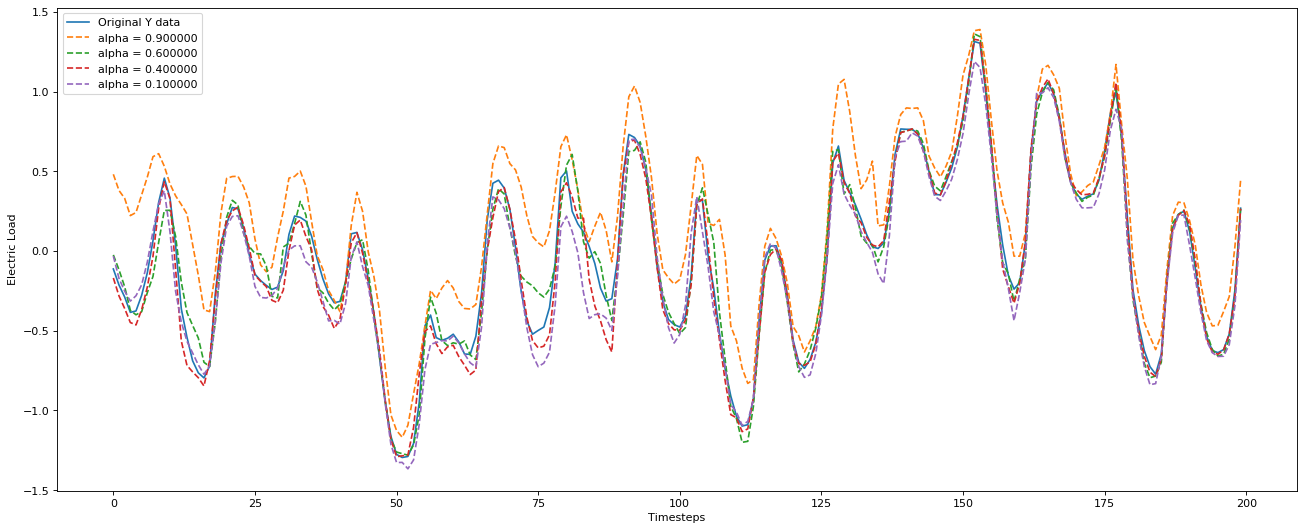

In [30]:
regressor = QuantileRegression(
        input_size = 25,
        hidden_size = 40,
        output_size = 1,
        num_layers = 1,
        seq_length = 12
    )

train_x = embedded_data.astype(np.float32)
train_y = target.astype(np.float32)



trainX = Variable(torch.from_numpy(train_x))
trainY = Variable(torch.from_numpy(train_y))
figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
layers  = 1
from_here = int(data_predict.shape[0] / layers)
plt.plot(dataY_plot[:200], label="Original Y data")
plt.xlabel('Timesteps')
plt.ylabel('Electric Load')

alpha_list = [0.9, 0.6, 0.4, 0.1]
for alpha in alpha_list:
    losses = regressor.train_model(
        trainX = trainX,
        trainY = trainY,
        lr = 0.005,
        epochs = 200,
        sample_size = 50,
        alpha=alpha
    )
    regressor.eval()
    train_predict = regressor(trainX)
    data_predict = train_predict.data.numpy()
    dataY_plot =  trainY.data.numpy()
    label_string = "alpha = %f"%(alpha)
    print(data_predict.shape, dataY_plot.shape)    
    plt.plot(data_predict[:200], '--' ,label=label_string)
plt.legend(loc='upper left')